In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))
base_dir = "/kaggle/input/aptos2019-blindness-detection"

['mbrset-data', 'kernel4f121f3249', 'aptos2019-blindness-detection']


In [2]:
print(os.listdir("/kaggle/input/kernel4f121f3249"))

['_results_.html', 'classifier.pt', '_notebook_.ipynb', '_output_.json', 'custom.css']


In [3]:
import seaborn as sns

In [4]:
train_csv = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
test_csv = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv")

In [5]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [6]:
train_csv.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

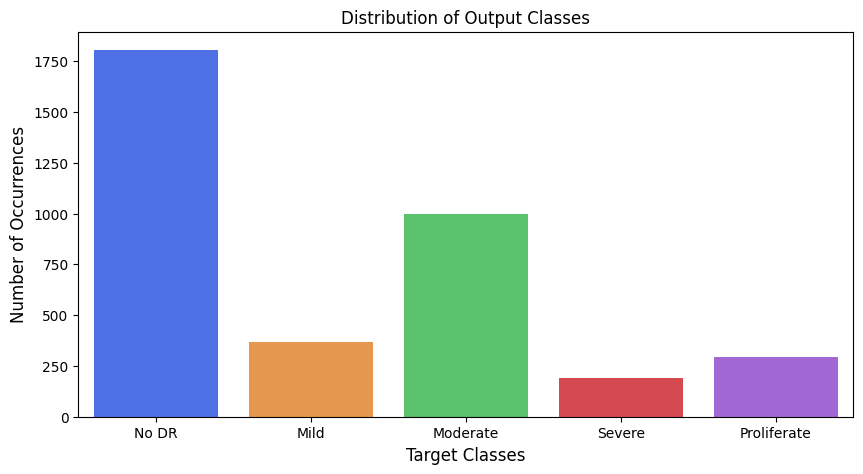

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_csv' is a pandas DataFrame and 'class_list' is defined
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i, x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10, 5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

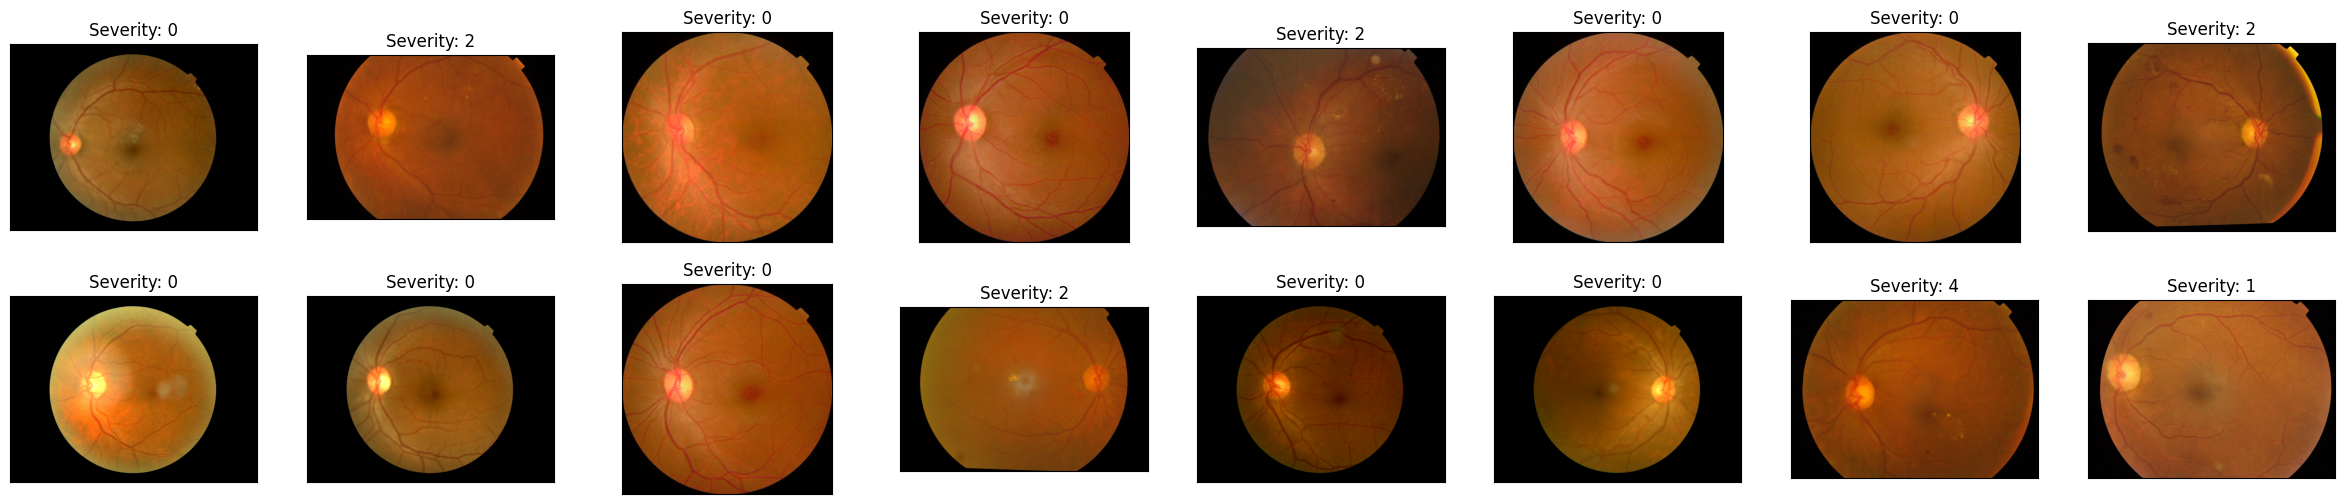

In [8]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

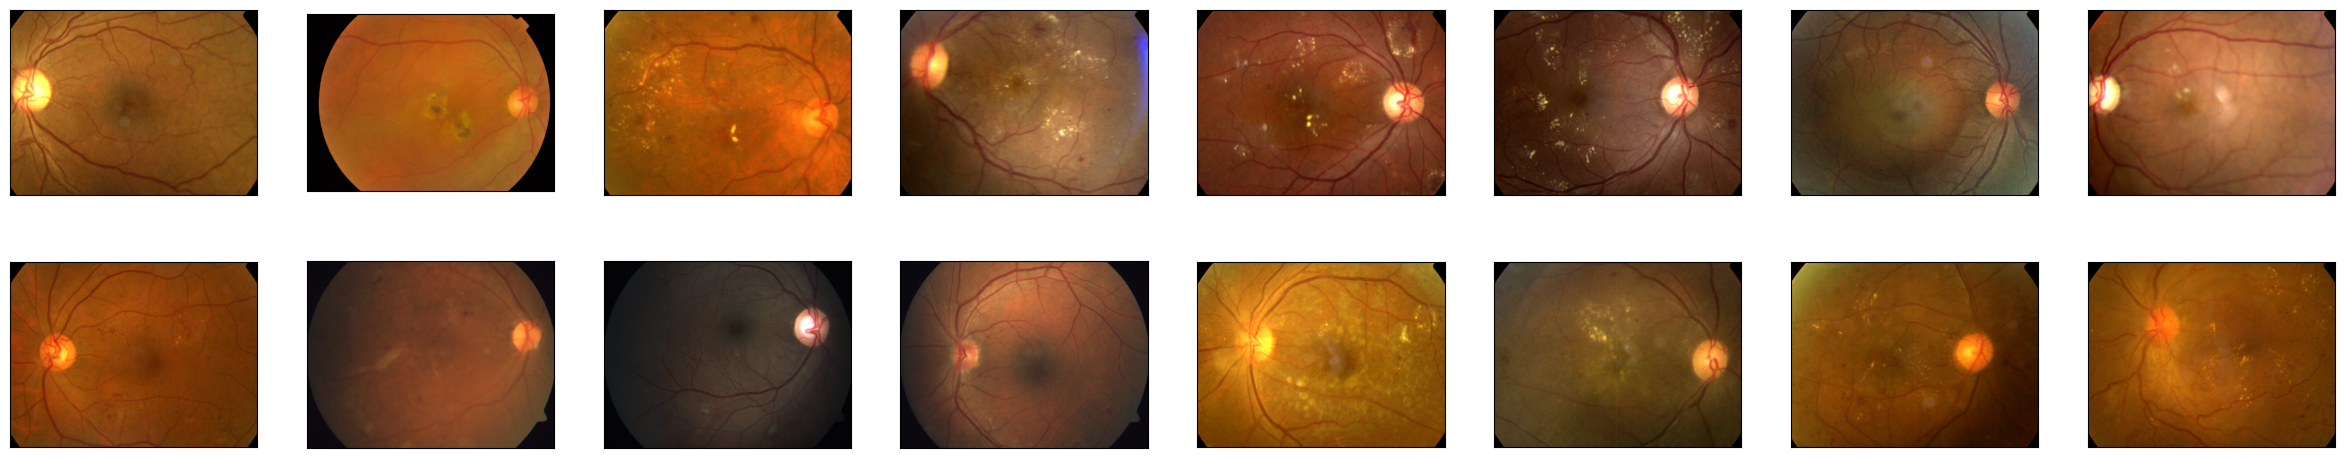

In [9]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

In [10]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [12]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [13]:
train_path = "/kaggle/input/aptos2019-blindness-detection/train_images"
test_path = "/kaggle/input/aptos2019-blindness-detection/test_images"

In [14]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [15]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [16]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [17]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [18]:
images, labels = next(iter(trainloader))


print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 4,
        1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 2, 0, 4, 2, 0, 0, 3, 0,
        1, 1, 2, 2, 2, 0, 4, 4, 0, 2, 2, 0, 2, 1, 3, 0])


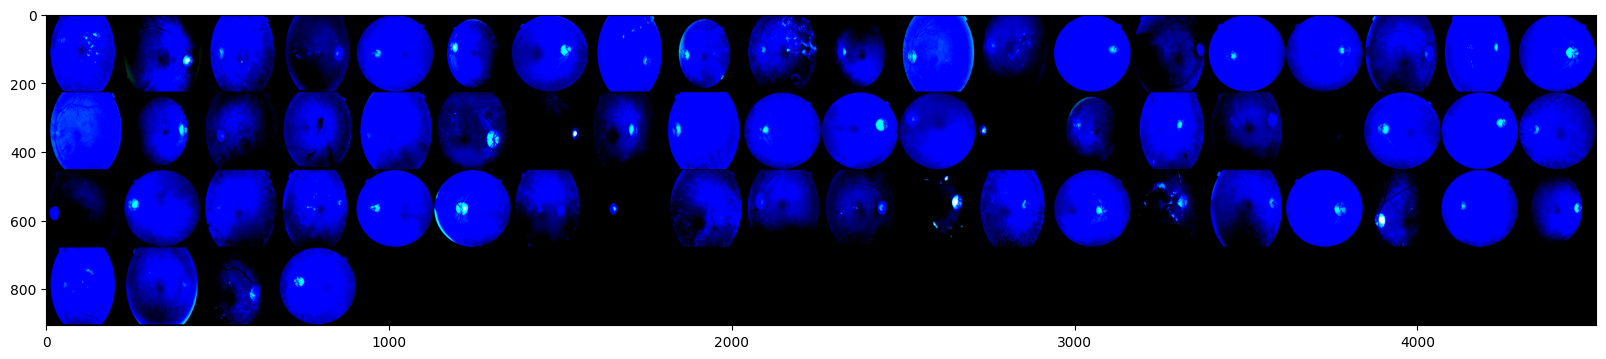

In [19]:

import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)  

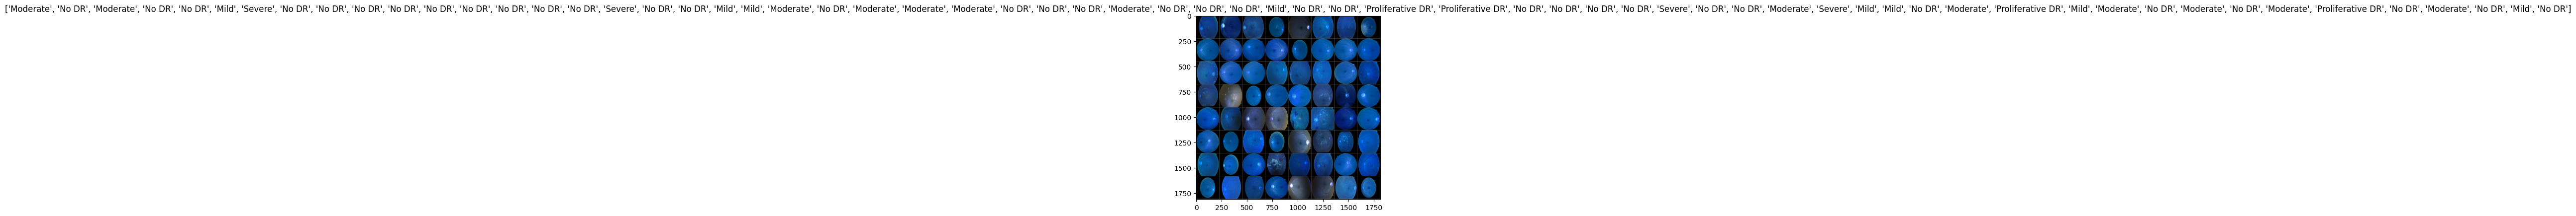

In [20]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [26]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 208MB/s]  


In [29]:
model_save_name = 'classifier.pt'
path = F"/kaggle/working/{model_save_name}"

In [30]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [31]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [32]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [33]:
# ONLY FOR GPU

import torch

def load_model(path):
    # Load the checkpoint with weights_only=False
    checkpoint = torch.load(path, weights_only=False)
    
    # Assuming the model architecture is defined elsewhere
    model = checkpoint['model']  # Extract the model from the checkpoint
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Path to the classifier.pt file
path = "/kaggle/input/kernel4f121f3249/classifier.pt"

# Load the model
model = load_model(path)

# Verify the model is loaded
print("Model loaded successfully!")





Model loaded successfully!


In [ ]:
#ONLY FOR CPU

import torch

def load_model(path):
    # Load the checkpoint with weights_only=False and map tensors to the CPU
    checkpoint = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
    
    # Assuming the model architecture is defined elsewhere
    model = checkpoint['model']  # Extract the model from the checkpoint
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Path to the classifier.pt file
path = "/kaggle/input/kernel4f121f3249/classifier.pt"

# Load the model
model = load_model(path)

# Verify the model is loaded
print("Model loaded successfully!")



In [34]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [36]:
def train_and_test(e):
    epochs = e
    train_losses, valid_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()  # Use .item() to get the scalar value
            batch_count += 1

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / batch_count
        train_losses.append(avg_train_loss)

        test_loss = 0.0
        accuracy = 0.0
        with torch.no_grad():
            print(f"Validation started for {epoch + 1}")
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels).item()  # Accumulate validation loss
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()  # Accumulate accuracy

        # Calculate average validation loss and accuracy for the epoch
        avg_valid_loss = test_loss / len(validloader)
        avg_accuracy = accuracy / len(validloader)

        valid_losses.append(avg_valid_loss)
        acc.append(avg_accuracy)

        scheduler.step()

        print(
            "Epoch: {}/{}.. ".format(epoch + 1, epochs),
            "Training Loss: {:.3f}.. ".format(avg_train_loss),
            "Validation Loss: {:.3f}.. ".format(avg_valid_loss),
            "Validation Accuracy: {:.3f}".format(avg_accuracy)
        )

        # Save the model if validation loss decreases
        if avg_valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, avg_valid_loss))
            path = "/kaggle/working/classifier.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_valid_loss
            }, path)
            valid_loss_min = avg_valid_loss

    print('Training Completed Successfully!')
    return train_losses, valid_losses, acc

train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
Validation started for 1
Epoch: 1/5..  Training Loss: 0.087..  Validation Loss: 0.063..  Validation Accuracy: 0.980
Validation loss decreased (inf --> 0.062769). Saving model ...
Validation started for 2
Epoch: 2/5..  Training Loss: 0.070..  Validation Loss: 0.075..  Validation Accuracy: 0.976
Validation started for 3
Epoch: 3/5..  Training Loss: 0.071..  Validation Loss: 0.068..  Validation Accuracy: 0.979
Validation started for 4
Epoch: 4/5..  Training Loss: 0.071..  Validation Loss: 0.074..  Validation Accuracy: 0.978
Validation started for 5
Epoch: 5/5..  Training Loss: 0.069..  Validation Loss: 0.066..  Validation Accuracy: 0.979
Training Completed Successfully!


In [37]:
print("Train Losses:", train_losses)
print("Validation Losses:", valid_losses)

Train Losses: [0.08691678864314505, 0.06974694371709357, 0.07115705222215342, 0.0710790163391958, 0.0686568322227053]
Validation Losses: [0.06276881555095315, 0.0747542812799414, 0.0677687341036896, 0.07397827350844939, 0.06643913158526023]


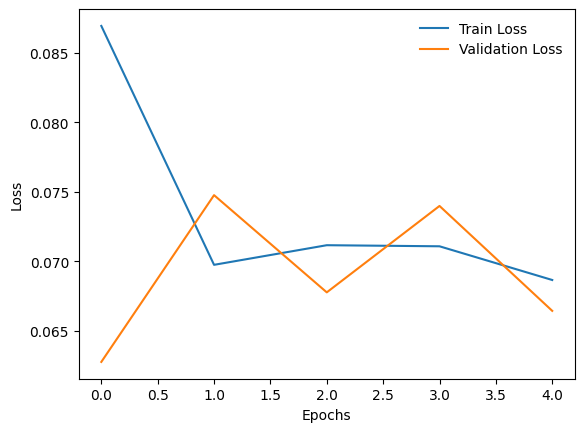

In [38]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

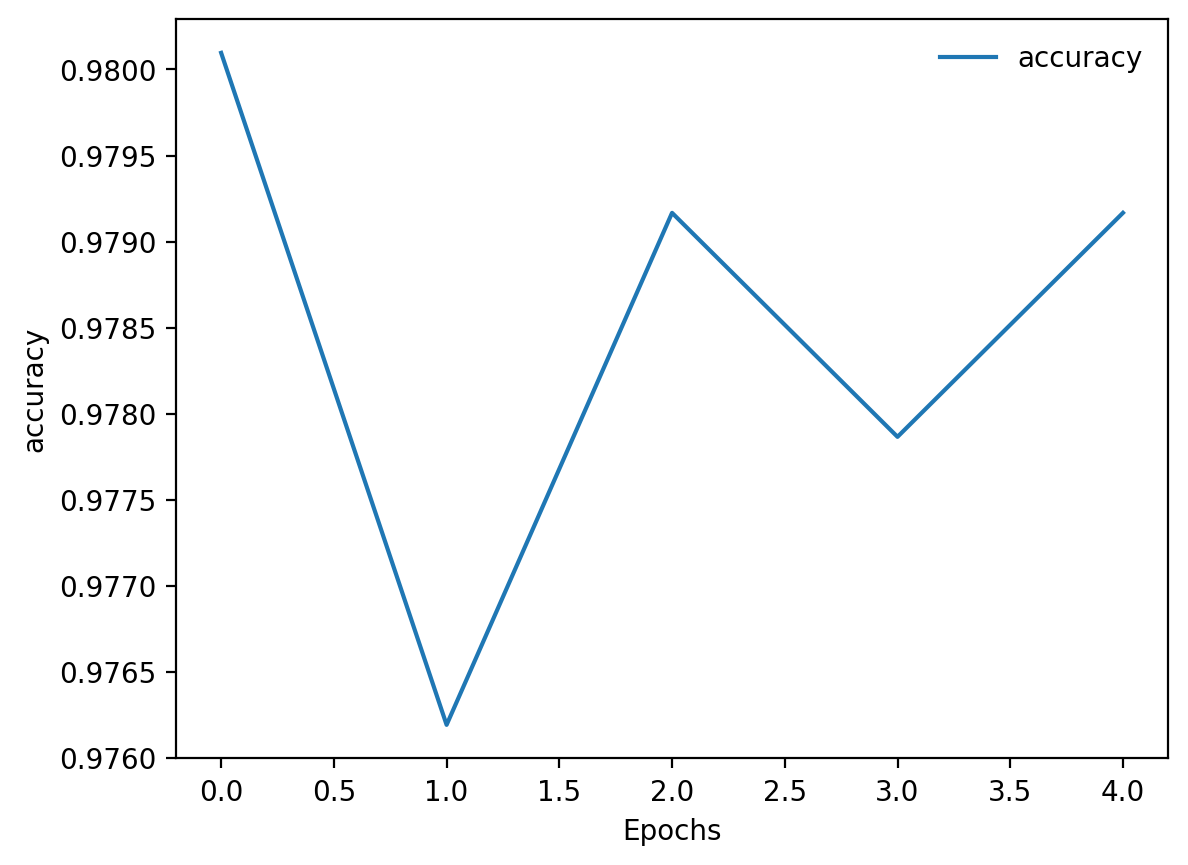

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)

In [40]:
import torch
from torchvision import models
import torch.nn as nn

def load_model(path):
    # Load the checkpoint
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    
    # Define the model architecture
    model = models.resnet152(pretrained=False)
    num_ftrs = model.fc.in_features
    
    # Modify the final layer to match the training architecture
    hidden_size = 512  # Replace with the correct hidden size used during training
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 5)
    )
    
    # Load the model's state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

In [41]:
# Path to the checkpoint file
path = "/kaggle/working/classifier.pt"

# Load the model
model = load_model(path)
print("Model loaded successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [42]:
from torchvision import transforms

# Define the transformation pipeline for inference
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Define the class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def predict_severity(image_path, model, transform):
    """
    Predicts the severity of Diabetic Retinopathy for a given image.
    
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained model for prediction.
        transform (torchvision.transforms.Compose): Transformation pipeline for preprocessing images.
    
    Returns:
        str: Predicted severity class.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    # Move the model and input tensor to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    # Disable gradients and perform inference
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class name
    predicted_class = class_names[predicted.item()]

    return predicted_class

In [44]:
# Example usage
image_path = "/kaggle/input/aptos2019-blindness-detection/test_images/0111b949947e.png"
predicted_severity = predict_severity(image_path, model, transform)
print(f"Predicted Severity: {predicted_severity}")

Predicted Severity: No DR


In [45]:
# Example usage
image_path = "/kaggle/input/aptos2019-blindness-detection/test_images/051d9d12a6ee.png"
predicted_severity = predict_severity(image_path, model, transform)
print(f"Predicted Severity: {predicted_severity}")

Predicted Severity: Moderate


In [46]:
import os

# Directory containing test images
test_images_dir = "/kaggle/input/aptos2019-blindness-detection/test_images"

# List all image files in the directory
image_files = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith(".png")]

# Predict severities for all images
predictions = []
for image_file in image_files:
    predicted_severity = predict_severity(image_file, model, transform)
    predictions.append({"Image": os.path.basename(image_file), "Predicted_Severity": predicted_severity})

# Display predictions
for pred in predictions:
    print(f"Image: {pred['Image']} -> Predicted Severity: {pred['Predicted_Severity']}")

Image: 755615db51d3.png -> Predicted Severity: Moderate
Image: d8f6c660bf2d.png -> Predicted Severity: Moderate
Image: 619ce2c77917.png -> Predicted Severity: Moderate
Image: 94a6e4f3c625.png -> Predicted Severity: No DR
Image: ee506d853270.png -> Predicted Severity: Moderate
Image: acd52452b9a2.png -> Predicted Severity: Moderate
Image: b0b0d564e6c6.png -> Predicted Severity: No DR
Image: 228769e96741.png -> Predicted Severity: No DR
Image: a87e705d63ee.png -> Predicted Severity: No DR
Image: 8c49d9de02d6.png -> Predicted Severity: No DR
Image: 69d21c5c7dce.png -> Predicted Severity: No DR
Image: 2f042d9c1376.png -> Predicted Severity: No DR
Image: c97946322879.png -> Predicted Severity: No DR
Image: 6dd2dbd802ea.png -> Predicted Severity: No DR
Image: e0ccaed5f4fc.png -> Predicted Severity: Moderate
Image: 4810eb8e7c88.png -> Predicted Severity: Moderate
Image: 49f6ffbc8356.png -> Predicted Severity: No DR
Image: f3a6c7df5fdc.png -> Predicted Severity: No DR
Image: 2c739d725e5e.png -

In [47]:
import pandas as pd

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(predictions)

# Save predictions to a CSV file
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(true_labels, predicted_labels):
    """
    Evaluates the model's performance using various metrics.
    
    Args:
        true_labels (list or numpy array): Ground truth labels.
        predicted_labels (list or numpy array): Predicted labels from the model.
    
    Returns:
        dict: Dictionary containing accuracy, precision, recall, F1-score, and confusion matrix.
    """
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, zero_division=0)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

In [52]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def predict_labels(dataloader, model, device):
    """
    Predicts labels for all images in a dataloader.
    
    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        model (torch.nn.Module): Trained model for prediction.
        device (torch.device): Device (CPU or GPU) to run inference on.
    
    Returns:
        tuple: True labels and predicted labels as lists.
    """
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Append true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return true_labels, predicted_labels

In [53]:
# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "/kaggle/working/classifier.pt"
model = load_model(model_path)
model.to(device)

# Get true and predicted labels for the validation set
true_labels, predicted_labels = predict_labels(validloader, model, device)

# Evaluate the model
metrics = evaluate_model(true_labels, predicted_labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.9781
Precision: 0.9783
Recall: 0.9781
F1-Score: 0.9782

Confusion Matrix:
[[360   1   0   0   0]
 [  0  71   1   0   1]
 [  0   1 194   1   3]
 [  0   0   2  33   2]
 [  0   0   3   1  58]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361
           1       0.97      0.97      0.97        73
           2       0.97      0.97      0.97       199
           3       0.94      0.89      0.92        37
           4       0.91      0.94      0.92        62

    accuracy                           0.98       732
   macro avg       0.96      0.95      0.96       732
weighted avg       0.98      0.98      0.98       732



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.9809
Precision: 0.9813
Recall: 0.9809
F1-Score: 0.9809

Confusion Matrix:
[[361   0   0   0   0]
 [  0  69   3   0   1]
 [  0   1 194   1   3]
 [  0   0   2  33   2]
 [  0   0   1   0  61]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361
           1       0.99      0.95      0.97        73
           2       0.97      0.97      0.97       199
           3       0.97      0.89      0.93        37
           4       0.91      0.98      0.95        62

    accuracy                           0.98       732
   macro avg       0.97      0.96      0.96       732
weighted avg       0.98      0.98      0.98       732



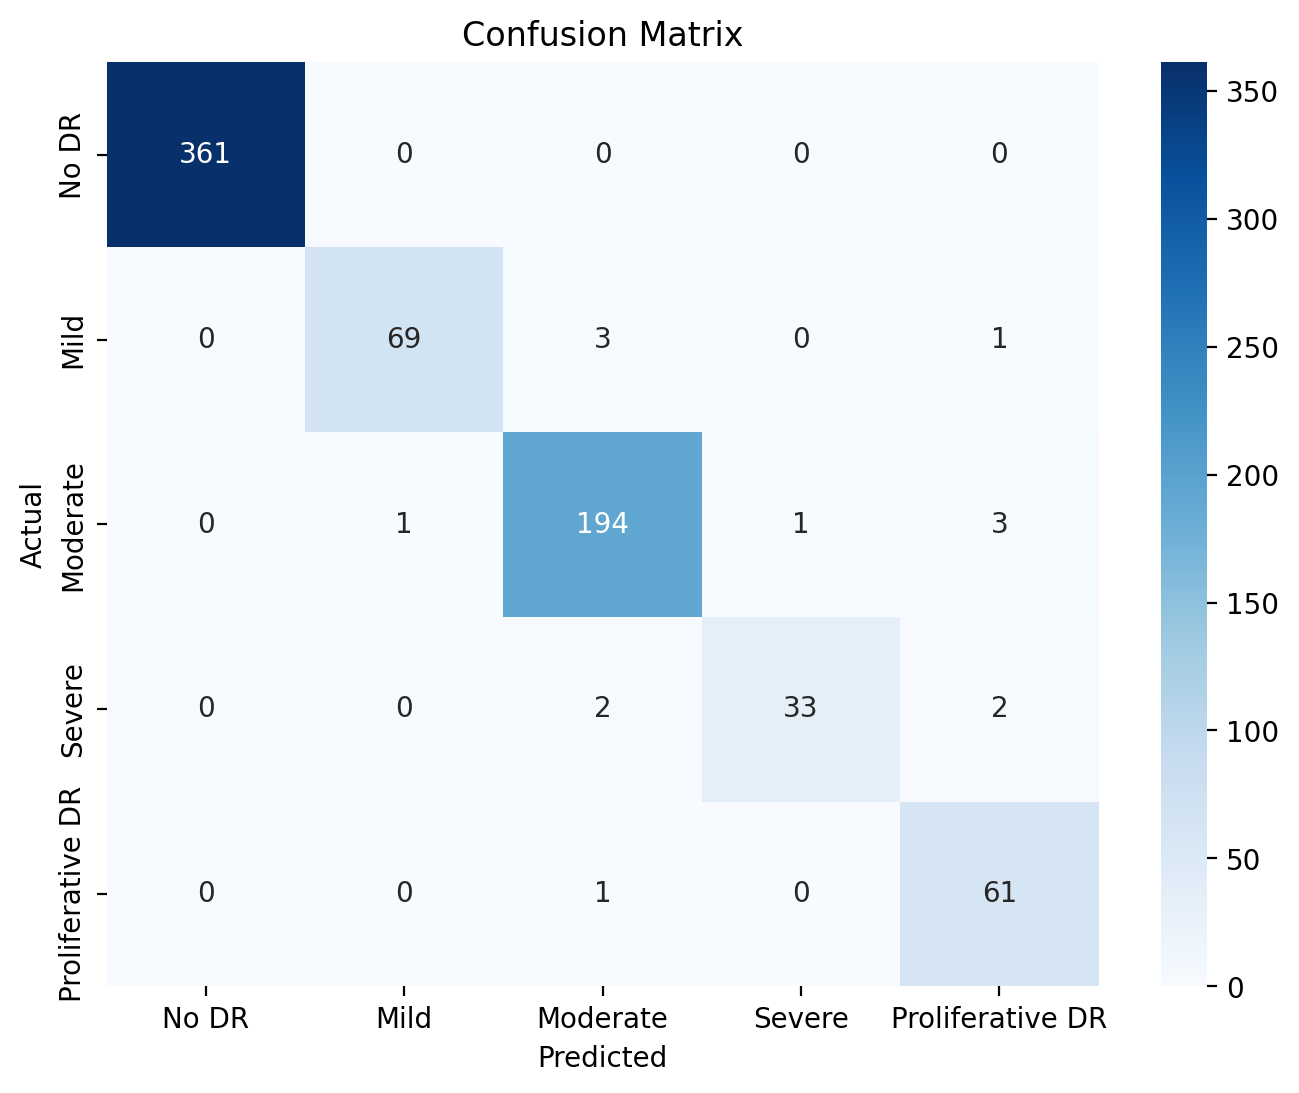

In [54]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def predict_labels(dataloader, model, device):
    """
    Predicts labels for all images in a dataloader.
    
    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        model (torch.nn.Module): Trained model for prediction.
        device (torch.device): Device (CPU or GPU) to run inference on.
    
    Returns:
        tuple: True labels and predicted labels as lists.
    """
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Append true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return true_labels, predicted_labels


def evaluate_model(true_labels, predicted_labels):
    """
    Evaluates the model's performance using various metrics.
    
    Args:
        true_labels (list or numpy array): Ground truth labels.
        predicted_labels (list or numpy array): Predicted labels from the model.
    
    Returns:
        dict: Dictionary containing accuracy, precision, recall, F1-score, and confusion matrix.
    """
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, zero_division=0)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }


def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        conf_matrix (numpy array): Confusion matrix to visualize.
        class_names (list): List of class names.
    """
    # Create a figure and axes
    plt.figure(figsize=(8, 6))
    
    # Plot the confusion matrix using seaborn
    sns.heatmap(
        conf_matrix,
        annot=True,              # Annotate each cell with its value
        fmt="d",                 # Format annotations as integers
        cmap="Blues",            # Use a blue colormap
        xticklabels=class_names, # Label the x-axis with class names
        yticklabels=class_names  # Label the y-axis with class names
    )
    
    # Add axis labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_path = "/kaggle/working/classifier.pt"
model = load_model(model_path)
model.to(device)

# Get true and predicted labels for the validation set
true_labels, predicted_labels = predict_labels(validloader, model, device)

# Evaluate the model
metrics = evaluate_model(true_labels, predicted_labels)

# Extract the confusion matrix from the metrics dictionary
conf_matrix = metrics["confusion_matrix"]

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)

**MBRSET DATA**

In [55]:
# Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Step 2: Define Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
# Step 3: Load the Dataset
# Define paths for the mBRSET dataset
data_dir = "/kaggle/input/mbrset-data/mBRSET Data"

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split the dataset into training and validation sets
valid_size = 0.2
num_samples = len(full_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_samples))
train_idx, valid_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=4
)

valid_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=4
)

# Test loader (if needed)
test_loader = DataLoader(
    datasets.ImageFolder(root=data_dir, transform=test_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# Print dataset statistics
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")
print(f"Classes: {full_dataset.classes}")

Number of training samples: 4884
Number of validation samples: 4884
Classes: ['0', '1', '2', '3', '4']


In [58]:
# Step 4: Define the Model
model = torchvision.models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
out_ftrs = 5  # Number of classes
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
# Step 5: Train the Model
def train_and_test(model, epochs, trainloader, validloader, criterion, optimizer, scheduler, device):
    train_losses, valid_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

        avg_train_loss = running_loss / batch_count
        train_losses.append(avg_train_loss)

        test_loss = 0.0
        accuracy = 0.0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels).item()
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        avg_valid_loss = test_loss / len(validloader)
        avg_accuracy = accuracy / len(validloader)
        valid_losses.append(avg_valid_loss)
        acc.append(avg_accuracy)

        scheduler.step()

        print(
            "Epoch: {}/{}.. ".format(epoch + 1, epochs),
            "Training Loss: {:.3f}.. ".format(avg_train_loss),
            "Validation Loss: {:.3f}.. ".format(avg_valid_loss),
            "Validation Accuracy: {:.3f}".format(avg_accuracy)
        )

        if avg_valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, avg_valid_loss))
            path = "/kaggle/working/best_model.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_valid_loss
            }, path)
            valid_loss_min = avg_valid_loss

    print('Training Completed Successfully!')
    return train_losses, valid_losses, acc

In [61]:
# Step 6: Evaluate the Model
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

def predict_labels(dataloader, model, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return true_labels, predicted_labels

# Evaluate the model on the validation set
true_labels, predicted_labels = predict_labels(valid_loader, model, device)
metrics = evaluate_model(true_labels, predicted_labels)

Accuracy: 0.7551
Precision: 0.5702
Recall: 0.7551
F1-Score: 0.6498
Confusion Matrix:
[[737   0   0   0   0]
 [ 50   0   0   0   0]
 [127   0   0   0   0]
 [ 18   0   0   0   0]
 [ 44   0   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       737
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       127
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        44

    accuracy                           0.76       976
   macro avg       0.15      0.20      0.17       976
weighted avg       0.57      0.76      0.65       976



In [62]:
# Step 2: Define Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [63]:
# Step 3: Load the Dataset
# Define paths for the mBRSET dataset
data_dir = "/kaggle/input/mbrset-data/mBRSET Data"

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split the dataset into training and validation sets
valid_size = 0.2
num_samples = len(full_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_samples))
train_idx, valid_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=4
)

valid_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=4
)

# Test loader (if needed)
test_loader = DataLoader(
    datasets.ImageFolder(root=data_dir, transform=test_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# Print dataset statistics
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")
print(f"Classes: {full_dataset.classes}")

Number of training samples: 4884
Number of validation samples: 4884
Classes: ['0', '1', '2', '3', '4']


In [64]:
# Step 4: Define the Model
model = torchvision.models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
out_ftrs = 5  # Number of classes
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
# Step 5: Train the Model
def train_and_test(model, epochs, trainloader, validloader, criterion, optimizer, scheduler, device):
    train_losses, valid_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")

    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

        avg_train_loss = running_loss / batch_count
        train_losses.append(avg_train_loss)

        test_loss = 0.0
        accuracy = 0.0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels).item()
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        avg_valid_loss = test_loss / len(validloader)
        avg_accuracy = accuracy / len(validloader)
        valid_losses.append(avg_valid_loss)
        acc.append(avg_accuracy)

        scheduler.step()

        print(
            "Epoch: {}/{}.. ".format(epoch + 1, epochs),
            "Training Loss: {:.3f}.. ".format(avg_train_loss),
            "Validation Loss: {:.3f}.. ".format(avg_valid_loss),
            "Validation Accuracy: {:.3f}".format(avg_accuracy)
        )

        if avg_valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, avg_valid_loss))
            path = "/kaggle/working/best_model.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_valid_loss
            }, path)
            valid_loss_min = avg_valid_loss

    print('Training Completed Successfully!')
    return train_losses, valid_losses, acc

In [69]:
# Step 6: Evaluate the Model
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

def predict_labels(dataloader, model, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return true_labels, predicted_labels

In [70]:
# Train the model
train_losses, valid_losses, acc = train_and_test(
    model=model,
    epochs=5,
    trainloader=train_loader,
    validloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)

# Evaluate the model on the validation set
true_labels, predicted_labels = predict_labels(valid_loader, model, device)
metrics = evaluate_model(true_labels, predicted_labels)

Model Training started.....
Epoch: 1/5..  Training Loss: 0.632..  Validation Loss: 0.626..  Validation Accuracy: 0.780
Validation loss decreased (inf --> 0.625796). Saving model ...
Epoch: 2/5..  Training Loss: 0.567..  Validation Loss: 0.602..  Validation Accuracy: 0.807
Validation loss decreased (0.625796 --> 0.602095). Saving model ...
Epoch: 3/5..  Training Loss: 0.475..  Validation Loss: 0.696..  Validation Accuracy: 0.776
Epoch: 4/5..  Training Loss: 0.429..  Validation Loss: 0.778..  Validation Accuracy: 0.826
Epoch: 5/5..  Training Loss: 0.287..  Validation Loss: 0.583..  Validation Accuracy: 0.837
Validation loss decreased (0.602095 --> 0.582920). Saving model ...
Training Completed Successfully!
Accuracy: 0.8371
Precision: 0.7693
Recall: 0.8371
F1-Score: 0.8001
Confusion Matrix:
[[743   0  14   0   2]
 [ 44   0   6   0   0]
 [ 57   0  46   0   3]
 [  1   0   9   0   7]
 [  6   0  10   0  28]]
Classification Report:
              precision    recall  f1-score   support

      

In [79]:
import os

print("Model saved:", os.path.exists("/kaggle/working/best_model.pth"))


Model saved: True


In [80]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import os

# Define the class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Define the transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model architecture
def load_trained_model(model_path):
    model = models.resnet152(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 5),
        torch.nn.LogSoftmax(dim=1)
    )
    
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Prediction function with correctness check
def predict_severity(image_path, model, transform, true_label=None):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()
    predicted_severity = class_names[predicted_class]

    print(f"Predicted Severity: {predicted_severity} (Class {predicted_class})")
    
    if true_label is not None:
        true_label = int(true_label)
        actual_severity = class_names[true_label]
        correctness = predicted_class == true_label
        print(f"Actual Severity: {actual_severity} (Class {true_label})")
        print(f"Prediction Correct: {'✅ Yes' if correctness else '❌ No'}")
        return predicted_class, correctness
    else:
        return predicted_class

# ==== USAGE EXAMPLE ====

# 1. Load the model
model_path = "/kaggle/working/best_model.pth"
model = load_trained_model(model_path)

# 2. Predict a sample image
image_path = "/kaggle/input/mbrset-data/mBRSET Data/2/1009.2.jpg"  # Replace with actual image path
true_class_label = 2  # Optional: if you know the correct class from folder name or label file

predict_severity(image_path, model, transform, true_label=true_class_label)


Predicted Severity: Moderate (Class 2)
Actual Severity: Moderate (Class 2)
Prediction Correct: ✅ Yes


(2, True)

In [81]:
import os
import torch
from PIL import Image
from torchvision import models, transforms

# Class names as per the 5 DR classes
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Transformation used in model training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load trained model
def load_trained_model(model_path):
    model = models.resnet152(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(num_ftrs, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 5),
        torch.nn.LogSoftmax(dim=1)
    )
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Extract true label from image path
def get_label_from_path(image_path):
    return int(os.path.basename(os.path.dirname(image_path)))

# Predict severity and compare with actual label
def predict_severity(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()
    predicted_severity = class_names[predicted_class]

    # True label from folder name
    true_label = get_label_from_path(image_path)
    actual_severity = class_names[true_label]
    correctness = predicted_class == true_label

    print(f"🖼️ Image: {os.path.basename(image_path)}")
    print(f"✅ Predicted: {predicted_severity} (Class {predicted_class})")
    print(f"📌 Actual:    {actual_severity} (Class {true_label})")
    print(f"🎯 Prediction Correct: {'✅ Yes' if correctness else '❌ No'}")

    return predicted_class, true_label, correctness


In [83]:
# Load trained model
model_path = "/kaggle/working/best_model.pth"
model = load_trained_model(model_path)

# Predict for a specific image
image_path = "/kaggle/input/mbrset-data/mBRSET Data/3/1098.4.jpg"
predict_severity(image_path, model, transform)


🖼️ Image: 1098.4.jpg
✅ Predicted: Proliferative DR (Class 4)
📌 Actual:    Severe (Class 3)
🎯 Prediction Correct: ❌ No


(4, 3, False)

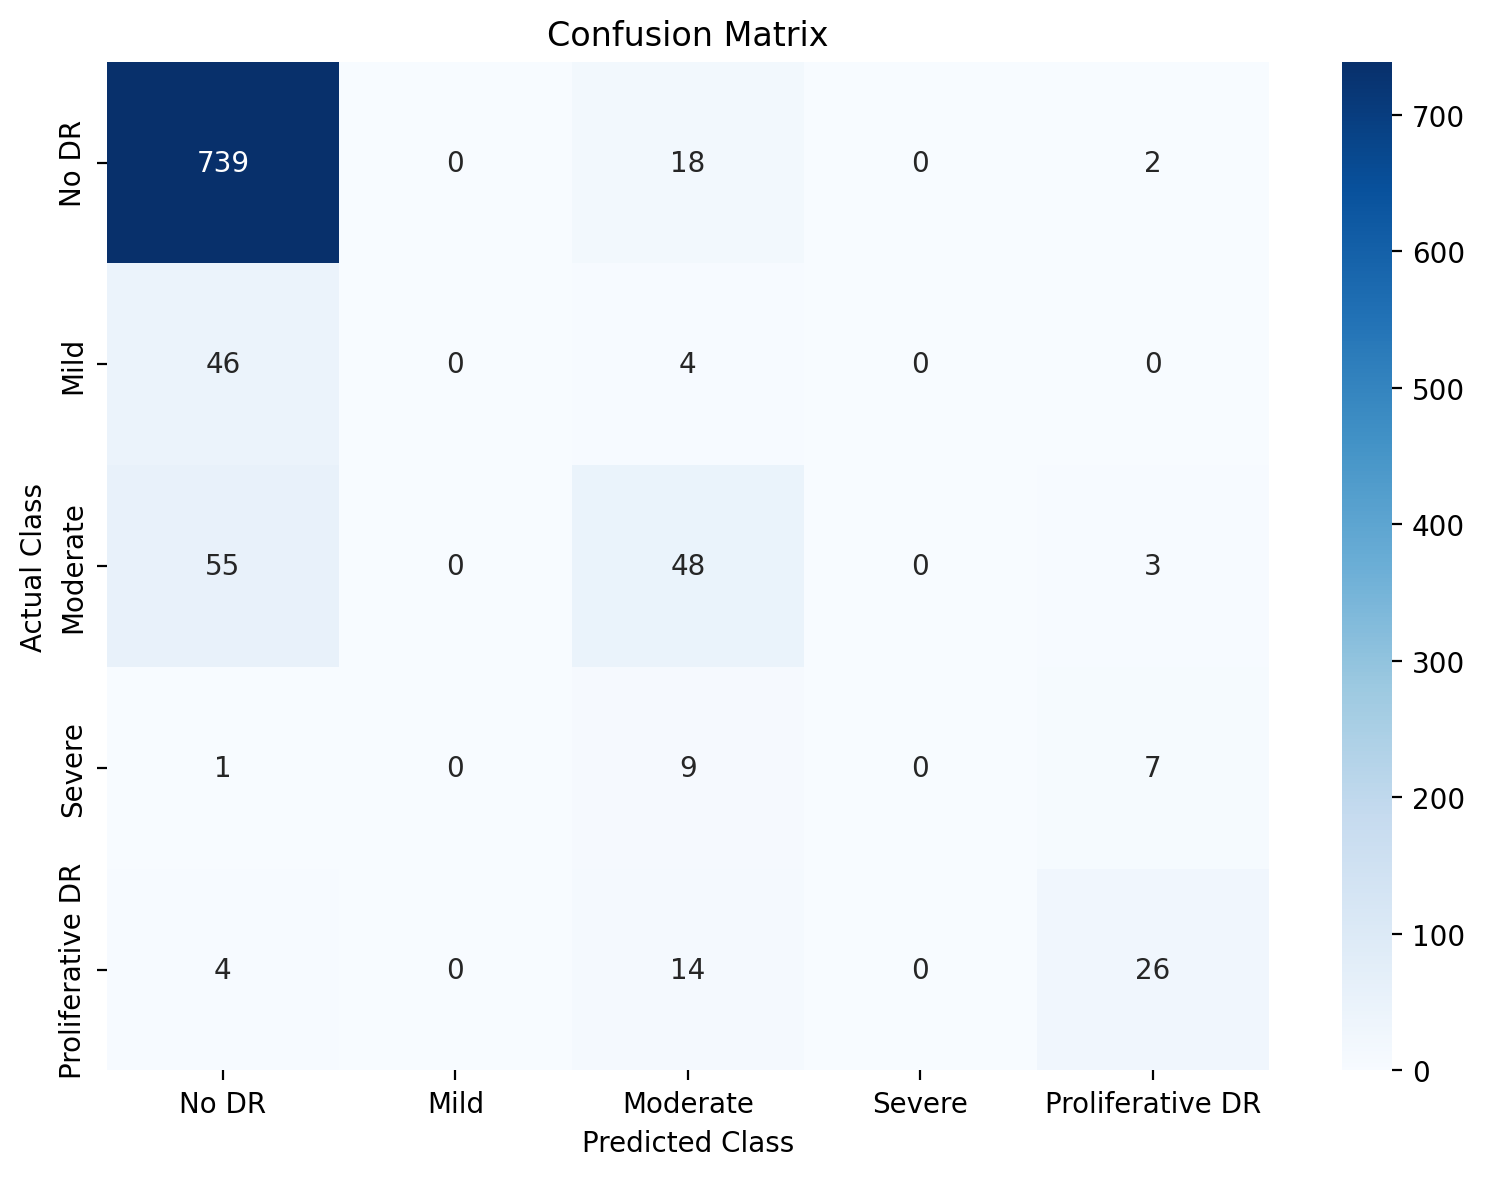

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Predict on validation set
true_labels, predicted_labels = predict_labels(valid_loader, model, device)

# 2. Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# 3. Class labels
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()


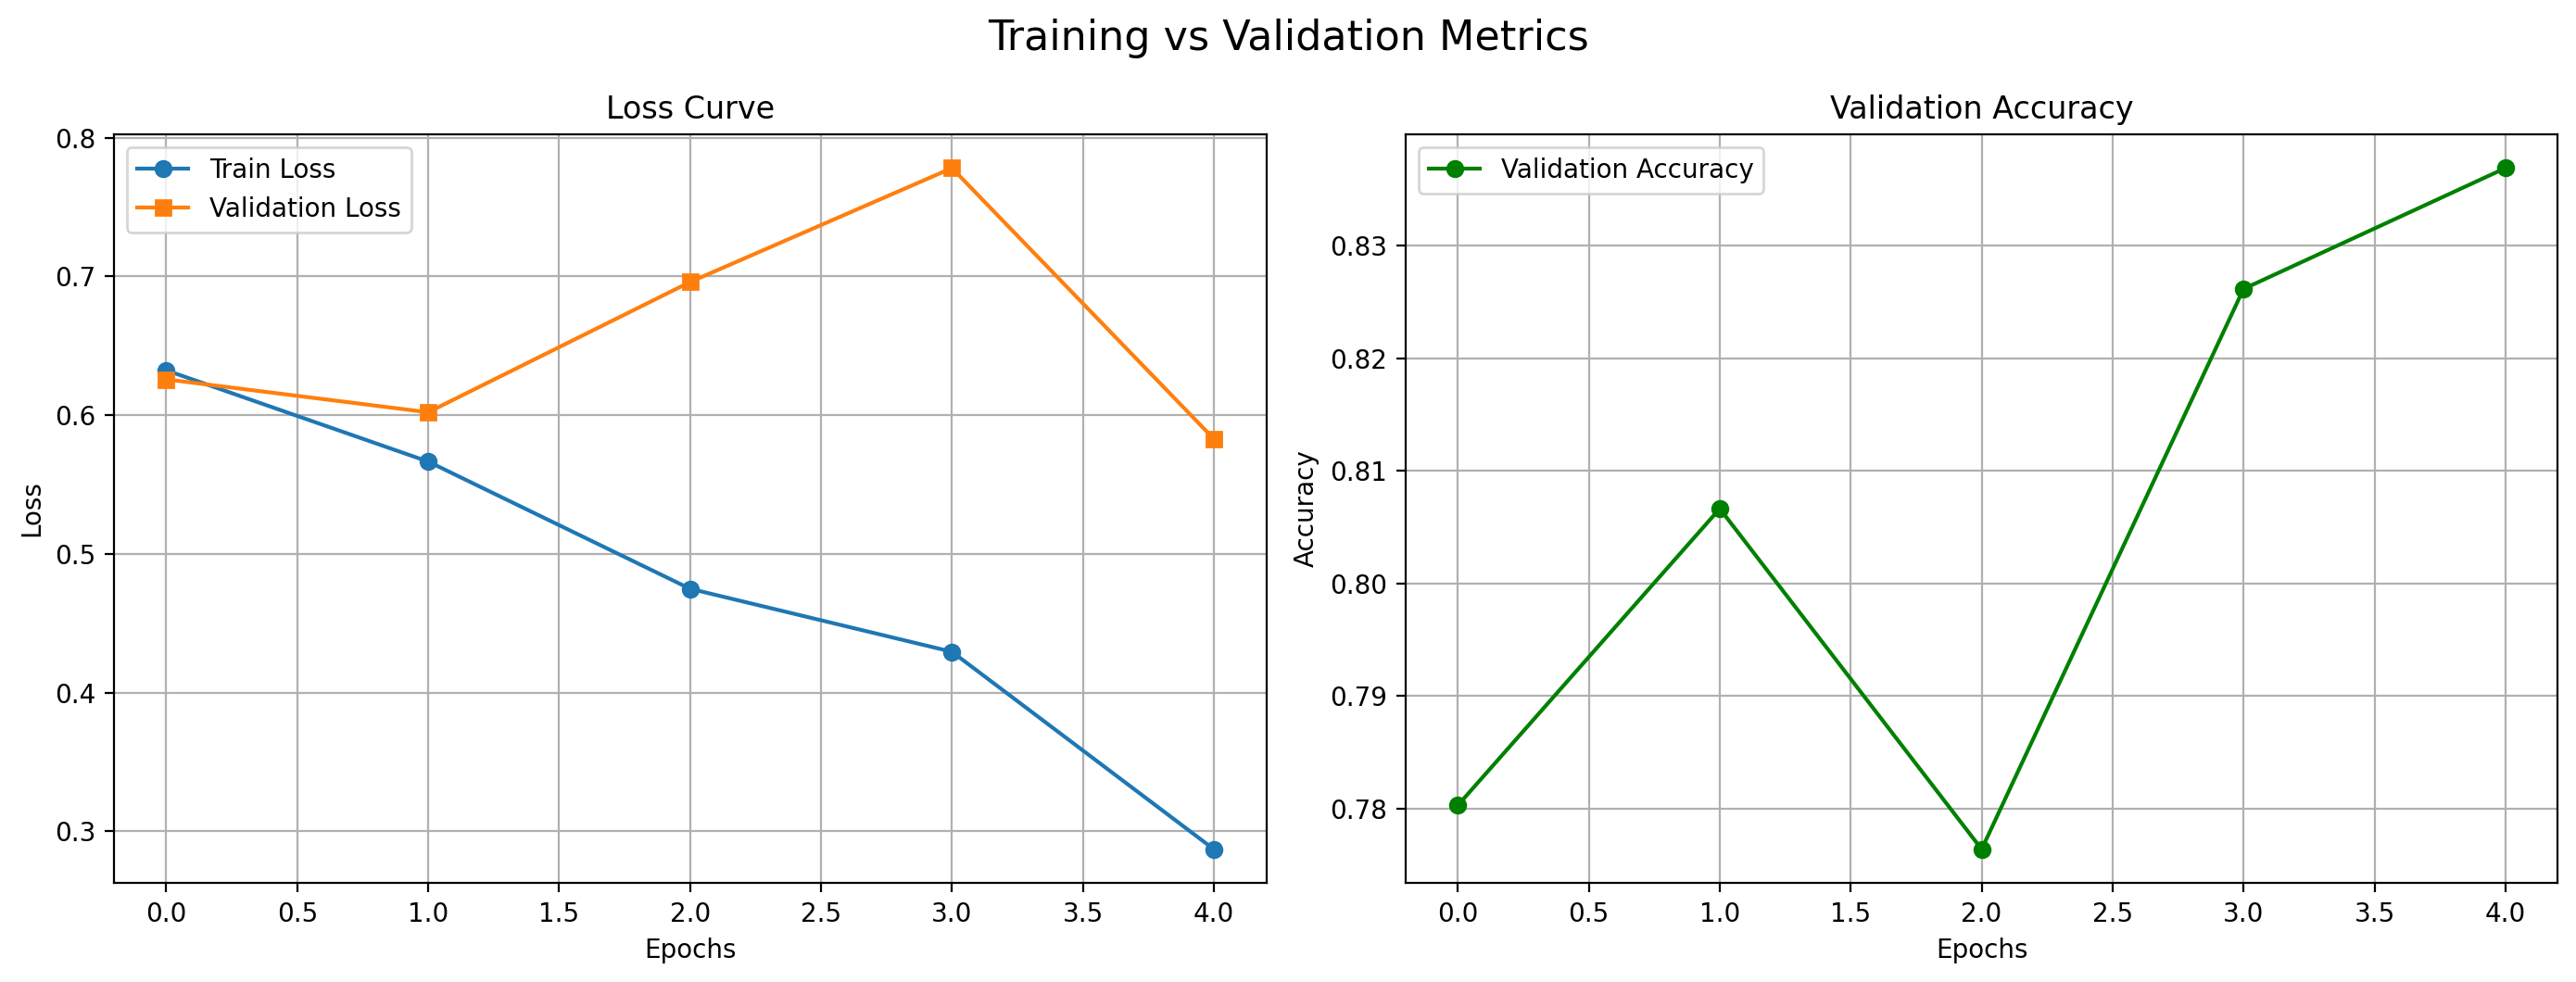

In [85]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (side-by-side or one below another)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot Training vs Validation Loss
axs[0].plot(train_losses, label='Train Loss', marker='o')
axs[0].plot(valid_losses, label='Validation Loss', marker='s')
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Training vs Validation Accuracy
# For fairness, training accuracy was not recorded, so we only plot validation accuracy
axs[1].plot(acc, label='Validation Accuracy', color='green', marker='o')
axs[1].set_title("Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

# Tight layout for better spacing
plt.tight_layout()
plt.suptitle("Training vs Validation Metrics", fontsize=16, y=1.05)
plt.show()


In [86]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Base directory of mBRSET dataset
base_dir = "/kaggle/input/mbrset-data/mBRSET Data"

# Class index to label
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_severity(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Store predictions
predictions = []

# Loop through dataset structure
for actual_class in sorted(os.listdir(base_dir)):
    actual_path = os.path.join(base_dir, actual_class)
    if not os.path.isdir(actual_path):
        continue
    
    for image_file in os.listdir(actual_path):
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(actual_path, image_file)
            try:
                predicted_idx = predict_severity(image_path, model, transform, device)
                predicted_label = class_names[predicted_idx]
                true_label = class_names[int(actual_class)]

                is_correct = (predicted_label == true_label)

                predictions.append({
                    "Image": image_file,
                    "Actual_Class": true_label,
                    "Predicted_Severity": predicted_label,
                    "Correct": is_correct
                })

                print(f"Image: {image_file} | Actual: {true_label} | Predicted: {predicted_label} | Correct: {is_correct}")
            
            except Exception as e:
                print(f"Error processing {image_file}: {e}")


Image: 824.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1309.4.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 978.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1324.4.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1001.4.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 358.4.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 603.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 898.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 243.2.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 668.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 759.3.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1035.4.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 577.2.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1150.1.jpg | Actual: No DR | Predicted: No DR | Correct: True
Image: 1179.3.jpg | Actual: No DR | Predict

In [87]:
import pandas as pd

# After your prediction loop is done:

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(predictions)

# Save to CSV file
output_csv_path = "mBRSET predictions.csv"
df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")


Predictions saved to mBRSET predictions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


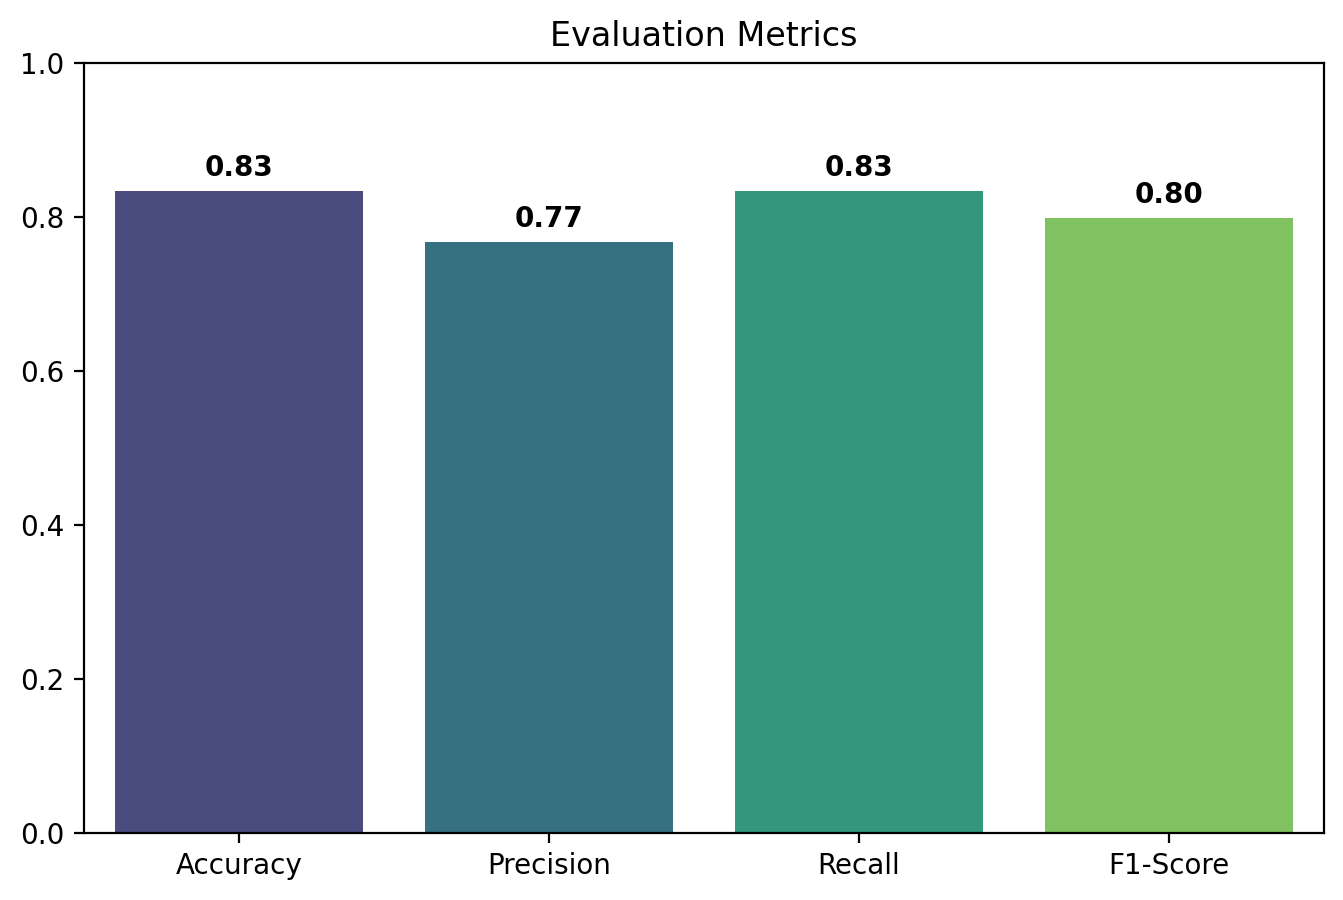

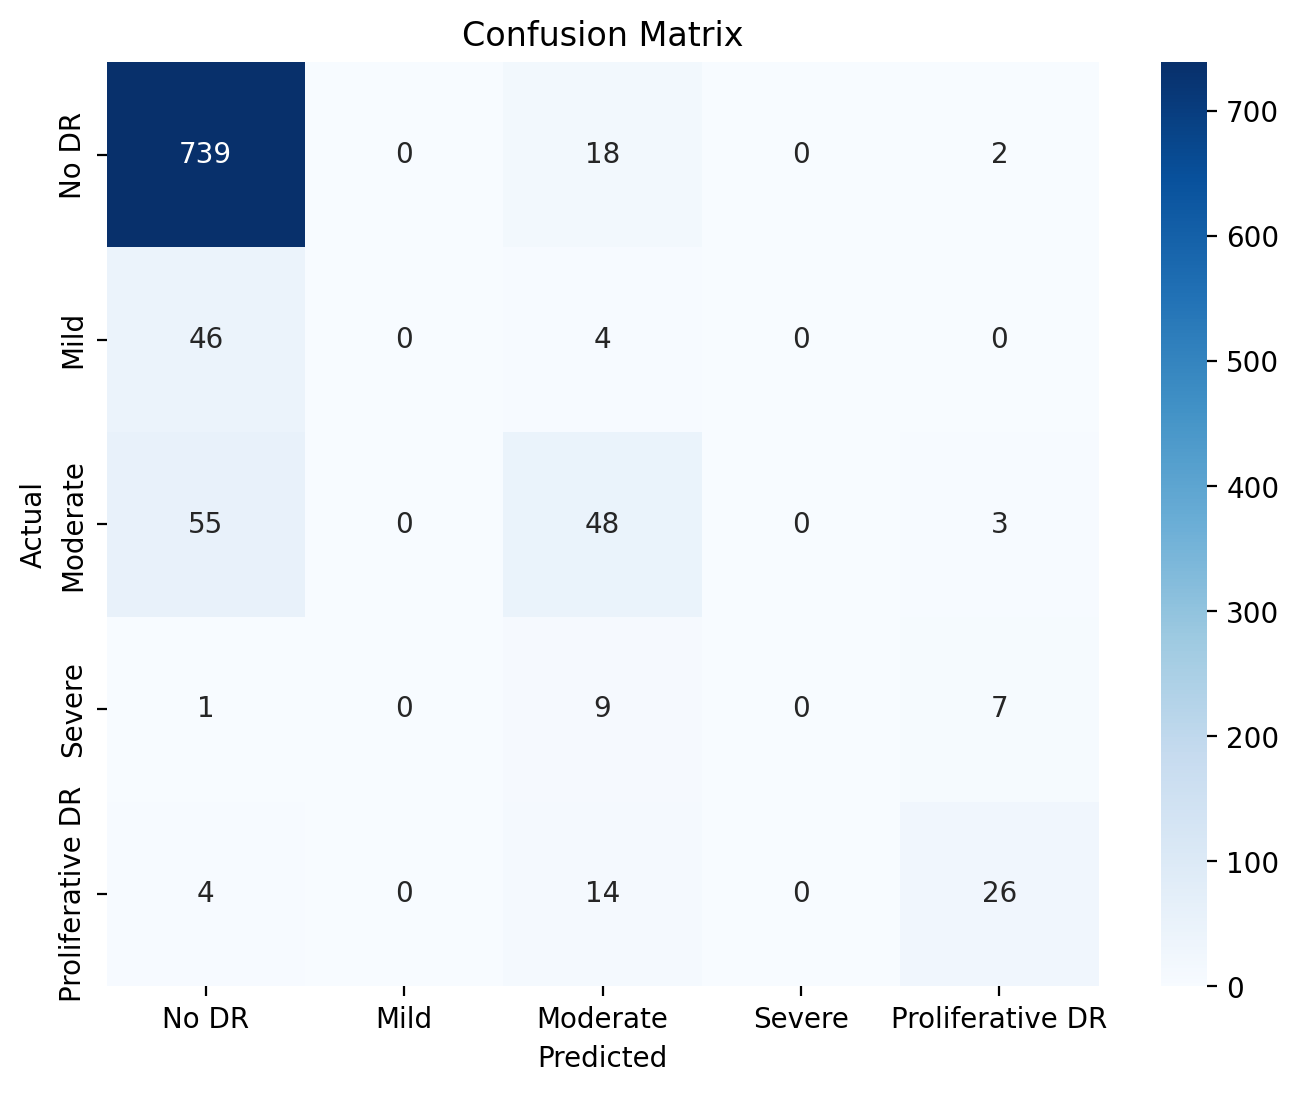

Classification Report:

                  precision    recall  f1-score   support

           No DR       0.87      0.97      0.92       759
            Mild       0.00      0.00      0.00        50
        Moderate       0.52      0.45      0.48       106
          Severe       0.00      0.00      0.00        17
Proliferative DR       0.68      0.59      0.63        44

        accuracy                           0.83       976
       macro avg       0.41      0.40      0.41       976
    weighted avg       0.77      0.83      0.80       976



In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def plot_evaluation_metrics(true_labels, predicted_labels, class_names):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    plt.figure(figsize=(8,5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
    plt.ylim([0,1])
    plt.title('Evaluation Metrics')
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0))

# Call the function now with your actual labels
plot_evaluation_metrics(true_labels, predicted_labels, class_names)
